In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pylab as pylab

In [ ]:
rossman_df = pd.read_csv("/content/drive/MyDrive/train.csv", low_memory=False)

In [ ]:
store_df = pd.read_csv("/content/drive/MyDrive/store.csv", low_memory=False)

In [ ]:
rossman_df.drop(rossman_df[rossman_df.Open == 0].index, inplace = True)
rossman_df.drop(rossman_df[rossman_df.Sales == 0].index, inplace = True)

In [ ]:
rossman_df['Date']=pd.to_datetime(rossman_df['Date'])
rossman_df['Year'] = rossman_df['Date'].apply(lambda x: x.year)
rossman_df['Month'] = rossman_df['Date'].apply(lambda x: x.month)
rossman_df['Day'] = rossman_df['Date'].apply(lambda x: x.day)

In [ ]:
rossman_df.drop(columns=['StateHoliday', 'Open'], inplace=True)

In [ ]:
store_df = store_df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)

In [ ]:
store_df.CompetitionDistance.fillna(store_df.CompetitionDistance.mode(), inplace=True)

In [ ]:
df = pd.merge(rossman_df, store_df, how='left', on='Store')

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [ ]:
df = remove_outlier(df, 'Sales')
df = remove_outlier(df, 'Customers')
df = remove_outlier(df, 'CompetitionDistance')

In [ ]:
df = pd.get_dummies(df,columns=['StoreType','Assortment'])

In [ ]:
df = df.drop(['Store','Date','Year'] , axis = 1)

In [ ]:
testing_sample = df.sample(n=30, random_state = 0)

In [ ]:
X = testing_sample.drop(['Sales'] , axis = 1)
y= testing_sample.Sales

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
import joblib

model_rf = joblib.load('/content/drive/MyDrive/random_forest.joblib')

In [ ]:
model_xg = joblib.load('/content/drive/MyDrive/xgboost.joblib')

In [ ]:
from tensorflow.keras.models import load_model

model_nn = load_model('/content/drive/MyDrive/nn_model.h5')

In [ ]:
rf_predict_initial = model_rf.predict(X)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [ ]:
xg_predict_initial = model_xg.predict(X)

In [ ]:
nn_predict_initial = model_nn.predict(X)

1/1 [==============================] - 0s 324ms/step


In [ ]:
nn_predict_squeezed = np.squeeze(nn_predict_initial)

In [ ]:
# rf_predict = (rf_predict_initial - np.min(rf_predict_initial))/(np.max(rf_predict_initial) - np.min(rf_predict_initial))
# xg_predict = (xg_predict_initial - np.min(xg_predict_initial))/(np.max(xg_predict_initial) - np.min(xg_predict_initial))
# nn_predict = (nn_predict_squeezed - np.min(nn_predict_squeezed))/(np.max(nn_predict_squeezed) - np.min(nn_predict_squeezed))

In [ ]:
# from scipy import stats

# rf_predict_yeo, _ = stats.yeojohnson(rf_predict_initial)

In [ ]:
# xg_predict_yeo, _ = stats.yeojohnson(xg_predict_initial)

In [ ]:
# nn_predict_yeo, _ = stats.yeojohnson(nn_predict_squeezed)

In [ ]:
# rf_predict_box, _ = stats.boxcox(rf_predict_initial)
# xg_predict_box, _ = stats.boxcox(xg_predict_initial)
# nn_predict_box, _ = stats.boxcox(nn_predict_squeezed)

In [ ]:
from scipy import stats

stats.wilcoxon(xg_predict_initial, nn_predict_squeezed)

WilcoxonResult(statistic=164.0, pvalue=0.1641840822994709)

In [ ]:
stats.levene(rf_predict_initial, xg_predict_initial, nn_predict_squeezed)

LeveneResult(statistic=0.21783483751952504, pvalue=0.8042709968140362)

<Axes: ylabel='Count'>

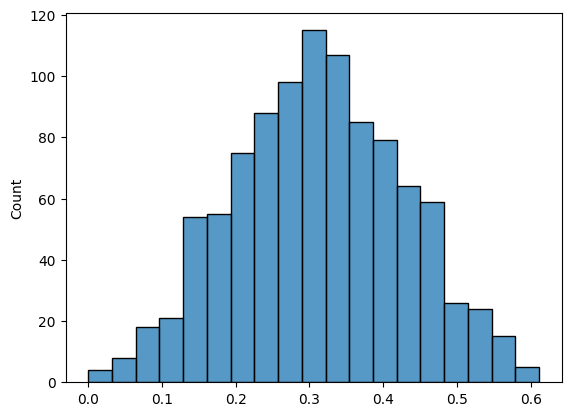

In [ ]:
sns.histplot(nn_predict_yeo)

In [ ]:
from scipy.stats import f_oneway

f_oneway(rf_predict_initial, xg_predict_initial, nn_predict_squeezed)

F_onewayResult(statistic=0.023896453217464343, pvalue=0.9763869922721944)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([rf_predict_initial, xg_predict_initial, nn_predict_squeezed])
ax.set_xticklabels(["Random Forest", "XGBoost", "Neural Network"])
ax.set_ylabel("Sales")
plt.show()

In [ ]:
print(stats.tukey_hsd(rf_predict_initial, xg_predict_initial, nn_predict_squeezed))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -17.448     0.985  -267.326   232.431
 (0 - 2)    -22.093     0.977  -271.971   227.786
 (1 - 0)     17.448     0.985  -232.431   267.326
 (1 - 2)     -4.645     0.999  -254.524   245.234
 (2 - 0)     22.093     0.977  -227.786   271.971
 (2 - 1)      4.645     0.999  -245.234   254.524



In [ ]:
from scipy import stats

stats.kruskal(rf_predict_initial, xg_predict_initial, nn_predict_squeezed)

KruskalResult(statistic=0.13734969146531464, pvalue=0.9336302045745226)